## Transfer learning and fine tuning for image classification

Image classification of Homer and Bart Simpson using transfer learning uses a pre-trained model like ResNet to recognize general features. Custom layers are added to classify these characters, and fine-tuning adjusts deeper layers to focus on unique traits for better accuracy.

### Transfer learning

Importing libraries

In [2]:
import tensorflow as tf
import seaborn as sns
import zipfile
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input,Dense,GlobalAveragePooling2D,Dropout
tf.__version__

'2.17.0'

Loading the images

In [3]:
#connect with google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!mkdir /content/my_new_folder

In [5]:
path='/content/my_new_folder/homer_bart_2.zip'
zip_object=zipfile.ZipFile(file=path,mode='r')
zip_object.extractall('./')
zip_object.close()

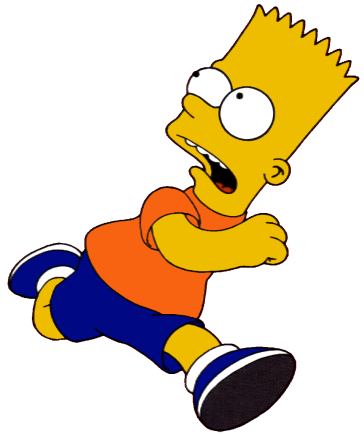

In [8]:
tf.keras.preprocessing.image.load_img('/content/homer_bart_2/training_set/bart/bart100.bmp')


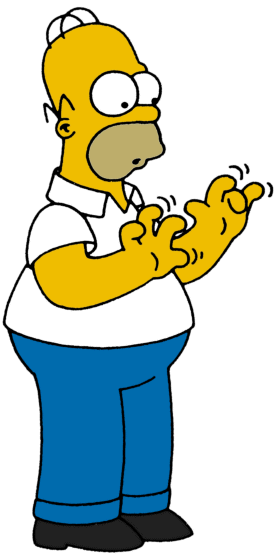

In [9]:
tf.keras.preprocessing.image.load_img('/content/homer_bart_2/training_set/homer/homer100.bmp')


### Train and test data

In [10]:
training_generator=ImageDataGenerator(rescale=1./255,
                                      rotation_range=7,
                                      horizontal_flip=True,
                                      zoom_range=0.2)
train_dataset=training_generator.flow_from_directory('/content/homer_bart_2/training_set',
                                                     target_size=(256,256),
                                                     batch_size=8,
                                                     class_mode='categorical',
                                                     shuffle=True)

Found 215 images belonging to 2 classes.


In [11]:
train_dataset.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

In [12]:
train_dataset.class_indices

{'bart': 0, 'homer': 1}

In [13]:
test_generator=ImageDataGenerator(rescale=1./255)
test_dataset=test_generator.flow_from_directory('/content/homer_bart_2/test_set',
                                               target_size=(256,256),
                                                batch_size=1,
                                                class_mode='categorical',
                                                shuffle=False
                                                )

Found 54 images belonging to 2 classes.


### Pre-trained neural network

In [14]:
base_model=tf.keras.applications.ResNet50(weights='imagenet',include_top=False,
                                          input_tensor=Input(shape=(256,256,3))) #ResNet50-the pretrained model that we are using here

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [15]:
base_model.summary()

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 262, 262, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 128, 128, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 128, 128, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 128, 128, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 130, 130, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 64, 64, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 64, 64, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 64, 64, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 64, 64, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 64, 64, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 64, 64, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 64, 64, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 64, 64, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 64, 64, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 23,534,592 (89.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [16]:
len(base_model.layers)

175

In [17]:
for layer in base_model.layers:
  layer.trainable=False

In [19]:
for layer in base_model.layers:
  print(layer,layer.trainable) #inorder to not change the values of each layer in the pretrained model

<InputLayer name=input_layer, built=True> False
<ZeroPadding2D name=conv1_pad, built=True> False
<Conv2D name=conv1_conv, built=True> False
<BatchNormalization name=conv1_bn, built=True> False
<Activation name=conv1_relu, built=True> False
<ZeroPadding2D name=pool1_pad, built=True> False
<MaxPooling2D name=pool1_pool, built=True> False
<Conv2D name=conv2_block1_1_conv, built=True> False
<BatchNormalization name=conv2_block1_1_bn, built=True> False
<Activation name=conv2_block1_1_relu, built=True> False
<Conv2D name=conv2_block1_2_conv, built=True> False
<BatchNormalization name=conv2_block1_2_bn, built=True> False
<Activation name=conv2_block1_2_relu, built=True> False
<Conv2D name=conv2_block1_0_conv, built=True> False
<Conv2D name=conv2_block1_3_conv, built=True> False
<BatchNormalization name=conv2_block1_0_bn, built=True> False
<BatchNormalization name=conv2_block1_3_bn, built=True> False
<Add name=conv2_block1_add, built=True> False
<Activation name=conv2_block1_out, built=True> F

### Custom dense layer

In [21]:
base_model.output#inorder to get the last layer

<KerasTensor shape=(None, 8, 8, 2048), dtype=float32, sparse=False, name=keras_tensor_174>

In [31]:
head_model=base_model.output
head_model=GlobalAveragePooling2D()(head_model)#connceting globalaveragepooling layer with last layer
head_model=Dense(units=1025,activation='relu')(head_model)#connecting globalaveragepooling layer with dense layer
head_model=Dropout(rate=0.2)(head_model)
head_model=Dense(units=1025,activation='relu')(head_model)#connecting globalaveragepooling layer with dense layer
head_model=Dropout(rate=0.2)(head_model)
head_model=Dense(2,activation='softmax')(head_model)#connecting dense layer with last layer
#(2048+2)/2=1025


### Building and training the neural network

In [26]:
base_model.input

[<KerasTensor shape=(None, 256, 256, 3), dtype=float32, sparse=None, name=keras_tensor>]

In [27]:
network=Model(inputs=base_model.input,outputs=head_model)

In [29]:
network.summary() #connected both neural networks

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 262, 262, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 128, 128, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 128, 128, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 128, 128, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 130, 130, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 64, 64, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 64, 64, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 64, 64, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 64, 64, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 64, 64, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 64, 64, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 64, 64, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 64, 64, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 64, 64, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 26,741,639 (102.01 MB)

 Trainable params: 3,153,927 (12.03 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [32]:
network.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [34]:
history=network.fit(train_dataset,epochs=10)

Epoch 1/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step - accuracy: 0.6792 - loss: 0.6309
Epoch 2/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step - accuracy: 0.6737 - loss: 0.5956
Epoch 3/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 58s 2s/step - accuracy: 0.7628 - loss: 0.5158
Epoch 4/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step - accuracy: 0.7323 - loss: 0.5179
Epoch 5/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 58s 2s/step - accuracy: 0.7339 - loss: 0.5355
Epoch 6/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 56s 2s/step - accuracy: 0.7171 - loss: 0.5100
Epoch 7/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - accuracy: 0.7971 - loss: 0.4727
Epoch 8/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 56s 2s/step - accuracy: 0.7157 - loss: 0.5313
Epoch 9/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - accuracy: 0.7232 - loss: 0.5357
Epoch 10/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 84s 2s/step - accuracy: 0.7265 - loss: 0.5082


### Evaluating the neural network

In [36]:
test_dataset.class_indices

{'bart': 0, 'homer': 1}

In [37]:
predictions=network.predict(test_dataset)
predictions

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


54/54 ━━━━━━━━━━━━━━━━━━━━ 17s 278ms/step


array([[0.7410645 , 0.25893548],
       [0.7952026 , 0.2047974 ],
       [0.09731878, 0.9026813 ],
       [0.87273234, 0.12726767],
       [0.8527981 , 0.14720193],
       [0.85412556, 0.14587446],
       [0.02003376, 0.9799662 ],
       [0.22627173, 0.77372825],
       [0.23823643, 0.76176363],
       [0.3124646 , 0.68753535],
       [0.12006475, 0.8799352 ],
       [0.73094267, 0.26905736],
       [0.7172057 , 0.2827943 ],
       [0.17278527, 0.8272148 ],
       [0.34563464, 0.65436536],
       [0.89452505, 0.10547496],
       [0.11065123, 0.88934875],
       [0.3188427 , 0.6811573 ],
       [0.6685683 , 0.33143172],
       [0.7698296 , 0.23017041],
       [0.07454   , 0.92546   ],
       [0.7786204 , 0.22137961],
       [0.97841007, 0.0215899 ],
       [0.5574055 , 0.44259456],
       [0.84208995, 0.15791008],
       [0.41539964, 0.58460045],
       [0.9799487 , 0.02005127],
       [0.850599  , 0.14940098],
       [0.02696576, 0.97303426],
       [0.04668443, 0.95331556],
       [0.

In [38]:
predictions=np.argmax(predictions,axis=1)
predictions

array([0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0,
       0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [39]:
#compare predicted and expected
test_dataset.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

In [40]:
#Accuracy
from sklearn.metrics import accuracy_score
accuracy_score(test_dataset.classes,predictions)

0.7777777777777778

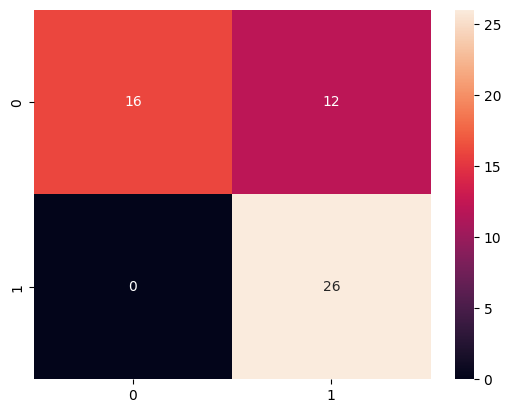

In [41]:


from sklearn.metrics import confusion_matrix
cm=confusion_matrix(test_dataset.classes,predictions)
sns.heatmap(cm,annot=True);

In [42]:
from sklearn.metrics import classification_report
print(classification_report(test_dataset.classes,predictions))

              precision    recall  f1-score   support

           0       1.00      0.57      0.73        28
           1       0.68      1.00      0.81        26

    accuracy                           0.78        54
   macro avg       0.84      0.79      0.77        54
weighted avg       0.85      0.78      0.77        54



So the neural network can correctly identify 57% of bart image and 100% of homer image

## Fine tuning

### Implementing

In [45]:
#unfreeze all base model
base_model.trainable=True

In [50]:
for layer in base_model.layers:
  print(layer,layer.trainable)

<InputLayer name=input_layer, built=True> False
<ZeroPadding2D name=conv1_pad, built=True> False
<Conv2D name=conv1_conv, built=True> False
<BatchNormalization name=conv1_bn, built=True> False
<Activation name=conv1_relu, built=True> False
<ZeroPadding2D name=pool1_pad, built=True> False
<MaxPooling2D name=pool1_pool, built=True> False
<Conv2D name=conv2_block1_1_conv, built=True> False
<BatchNormalization name=conv2_block1_1_bn, built=True> False
<Activation name=conv2_block1_1_relu, built=True> False
<Conv2D name=conv2_block1_2_conv, built=True> False
<BatchNormalization name=conv2_block1_2_bn, built=True> False
<Activation name=conv2_block1_2_relu, built=True> False
<Conv2D name=conv2_block1_0_conv, built=True> False
<Conv2D name=conv2_block1_3_conv, built=True> False
<BatchNormalization name=conv2_block1_0_bn, built=True> False
<BatchNormalization name=conv2_block1_3_bn, built=True> False
<Add name=conv2_block1_add, built=True> False
<Activation name=conv2_block1_out, built=True> F

In [47]:
len(base_model.layers)

175

In [48]:
fine_tuning_at=140

In [49]:
for layer in base_model.layers[:fine_tuning_at]:
  layer.trainable=False

In [51]:
network.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])



In [52]:
history=network.fit(train_dataset,epochs=10)

Epoch 1/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 75s 2s/step - accuracy: 0.7100 - loss: 0.5198
Epoch 2/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 78s 2s/step - accuracy: 0.7144 - loss: 0.5614
Epoch 3/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step - accuracy: 0.8043 - loss: 0.4556
Epoch 4/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step - accuracy: 0.8242 - loss: 0.4065
Epoch 5/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 84s 2s/step - accuracy: 0.8098 - loss: 0.3687
Epoch 6/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 79s 2s/step - accuracy: 0.7897 - loss: 0.4440
Epoch 7/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step - accuracy: 0.8290 - loss: 0.3914
Epoch 8/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 58s 2s/step - accuracy: 0.7678 - loss: 0.5747
Epoch 9/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step - accuracy: 0.8177 - loss: 0.4243
Epoch 10/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - accuracy: 0.8322 - loss: 0.4049


### Evaluate

In [53]:
predictions=network.predict(test_dataset)
predictions


54/54 ━━━━━━━━━━━━━━━━━━━━ 17s 276ms/step


array([[9.21777666e-01, 7.82223046e-02],
       [8.56161773e-01, 1.43838167e-01],
       [3.29323947e-01, 6.70676112e-01],
       [9.44112957e-01, 5.58870398e-02],
       [9.55445826e-01, 4.45542224e-02],
       [9.29932654e-01, 7.00673983e-02],
       [8.91829375e-03, 9.91081715e-01],
       [6.17381752e-01, 3.82618278e-01],
       [5.61762154e-01, 4.38237786e-01],
       [4.72608805e-01, 5.27391255e-01],
       [1.37054458e-01, 8.62945497e-01],
       [9.06850874e-01, 9.31491405e-02],
       [9.25236762e-01, 7.47632533e-02],
       [2.40463570e-01, 7.59536505e-01],
       [7.23674357e-01, 2.76325643e-01],
       [9.63905990e-01, 3.60939838e-02],
       [1.27468571e-01, 8.72531414e-01],
       [3.70507061e-01, 6.29492939e-01],
       [8.70865107e-01, 1.29134879e-01],
       [9.16177452e-01, 8.38225409e-02],
       [9.89244655e-02, 9.01075542e-01],
       [9.25119698e-01, 7.48802945e-02],
       [9.95210230e-01, 4.78981109e-03],
       [7.38692999e-01, 2.61307061e-01],
       [9.450007

In [54]:
predictions=np.argmax(predictions,axis=1)
predictions

array([0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1])

In [55]:
test_dataset.classes
#compainring both the prediction and expected output

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

In [56]:
from sklearn.metrics import accuracy_score
accuracy_score(test_dataset.classes,predictions)

0.8148148148148148

So the accuracy score is better than transfer learning

### Saving and loading the model

In [57]:
#saving in json format
model_json=network.to_json()
with open('network.json','w') as json_file:
  json_file.write(model_json)

In [58]:
from keras.models import save_model
save_model(network,'/content/weights.hdf5')

In [60]:
with open('network.json') as json_file:
  json_saved_model=json_file.read()
json_saved_model

'{"module": "keras.src.models.functional", "class_name": "Functional", "config": {"name": "functional", "trainable": true, "layers": [{"module": "keras.layers", "class_name": "InputLayer", "config": {"batch_shape": [null, 256, 256, 3], "dtype": "float32", "sparse": false, "name": "input_layer"}, "registered_name": null, "name": "input_layer", "inbound_nodes": []}, {"module": "keras.layers", "class_name": "ZeroPadding2D", "config": {"name": "conv1_pad", "trainable": false, "dtype": {"module": "keras", "class_name": "DTypePolicy", "config": {"name": "float32"}, "registered_name": null}, "padding": [[3, 3], [3, 3]], "data_format": "channels_last"}, "registered_name": null, "build_config": {"input_shape": [null, 256, 256, 3]}, "name": "conv1_pad", "inbound_nodes": [{"args": [{"class_name": "__keras_tensor__", "config": {"shape": [null, 256, 256, 3], "dtype": "float32", "keras_history": ["input_layer", 0, 0]}}], "kwargs": {}}]}, {"module": "keras.layers", "class_name": "Conv2D", "config": {

In [61]:
# Load the model architecture from JSON
network_loaded = tf.keras.models.model_from_json(json_saved_model)

# Load weights into the model
network_loaded.load_weights('weights.hdf5')

# Compile the loaded model
network_loaded.compile(
    loss='categorical_crossentropy',
    optimizer='Adam',
    metrics=['accuracy']
)

In [62]:
network_loaded.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 262, 262, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 128, 128, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 128, 128, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 128, 128, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 130, 130, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 64, 64, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 64, 64, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 64, 64, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 64, 64, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 64, 64, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 64, 64, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 64, 64, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 64, 64, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 64, 64, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 26,741,639 (102.01 MB)

 Trainable params: 3,153,927 (12.03 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

### Classifying one single image

In [71]:
image=cv2.imread('/content/homer_bart_2/test_set/homer/homer17.bmp')

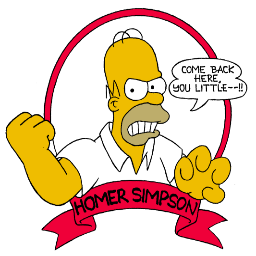

In [72]:
#reshape the image
image=cv2.resize(image,(256,256))
cv2_imshow(image)

array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]], dtype=uint8)
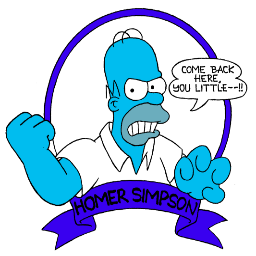

In [73]:
image

In [74]:
#normalizing the data
image=image/255
image

array([[[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]],

       [[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]],

       [[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]],

       ...,

       [[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]],

       [[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]],

       [[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]]])

In [75]:
image.shape

(256, 256, 3)

In [76]:
#converting to batch format
image=image.reshape(-1,256,256,3)
image.shape

(1, 256, 256, 3)

In [77]:
result=network_loaded.predict(image)
result

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step


array([[0.00449735, 0.99550265]], dtype=float32)

In [78]:
result=np.argmax(result)
result

1

In [79]:
test_dataset.class_indices

{'bart': 0, 'homer': 1}

In [80]:

if result==0:
  print('Bart')
else:
  print('Homer')

Homer


So it predicted the image correctly as Homer

Introducing fine tuning for image classification enhances accuracy by allowing the model to focus on unique character traits, ensuring that images are classified correctly, such as accurately distinguishing Homer from Bart.